# Flowers Analysis
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

102 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 102 different categories. 
The images were acquired by searching the web and taking pictures. There are a
minimum of 40 images for each category.

The images are contained in the file 102flowers.tgz and the image labels in
imagelabels.mat.

We provide 4 distance matrices. D_hsv, D_hog, D_siftint, D_siftbdy. These
are the chi^2 distance matrices used in the publication below.

The database was used in:

Nilsback, M-E. and Zisserman, A. Automated flower classification over a large number of classes.
Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing (2008) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.{pdf,ps.gz}.

Datasplit
------------------------------------------------
The datasplits used in this paper are specified in setid.mat.

The results in the paper are produced on a 103 category database. The two
categories labeled Petunia have since been merged since they are the same.
There is a training file (trnid), a validation file (valid)
and a testfile (tstid). 

Segmentation Images
------------------------------------------------
We provide the segmentations for the images in the file 102segmentations.tgz

More details can be found in:

Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmenation.
Proceedings of the British Machine Vision Conference (2007)
http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback07.(pdf,ps.gz).
.

History
-----------------------------------------------
version 1.1 - Two petunia categories merged into one. 

# Requirements

In [1]:
from google.colab import drive

from os import listdir
from os.path import isfile, join
import os.path
from os import path

import tarfile
import glob

import tensorflow as tf
import sklearn 
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import scipy
from scipy import io

import PIL
from PIL import Image
import cv2
import seaborn as sns

In [2]:
drive.mount('/content/gdrive', force_remount=True)
PATH_PROJ = "/content/gdrive/MyDrive/AML-proj/" 
if not path.exists(PATH_PROJ):
    PATH_PROJ = "/content/gdrive/Shareddrives/AML-proj/"  # TODO: check if it is correct!

PATH_JPG = "/content/jpg_augmented/"
PATH_TAR = PATH_PROJ + "102flowers_augmented.tar"
PATH_AUG = PATH_PROJ + "jpg_augmented/"
IMG_SIZE = 224
NUM_CLASSES = 102

NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

NAMES_ID = dict(zip(NAMES, [x for x in range(len(NAMES))]))
ID_NAMES = dict(zip([x for x in range(len(NAMES))], NAMES))

Mounted at /content/gdrive


# Functions

In [3]:
def execute_pca_on_imgs(img, show=False):
  # Splitting the image in R,G,B arrays.
  b, g, r = cv2.split(img) 
  #it will split the original image into Blue, Green and Red arrays.

  # it is mandatory to do feature scaling before applying PCA because PCA directions are highly sensitive to the relative ranges of features
  r_scaled = r / 255
  g_scaled = g / 255
  b_scaled = b / 255

  #initialize PCA with at least 95% variance  
  pca_r = PCA(0.95)
  pca_r_trans = pca_r.fit_transform(r_scaled)

  pca_g = PCA(0.95)
  pca_g_trans = pca_g.fit_transform(g_scaled)

  pca_b = PCA(0.95)
  pca_b_trans = pca_b.fit_transform(b_scaled)

  # inverse
  pca_r_org = pca_r.inverse_transform(pca_r_trans)
  pca_g_org = pca_g.inverse_transform(pca_g_trans)
  pca_b_org = pca_b.inverse_transform(pca_b_trans)

  # compressiong
  img_compressed = cv2.merge((pca_b_org, pca_g_org, pca_r_org))
  #viewing the compressed image
  if show: 
    plt.imshow(img_compressed)
    plt.show()

  return img_compressed
    

def execute_pca_on_imgs_set(df, path = PATH_JPG):
  for img_name in df["Id"]:
    RGB_img = plt.imread(path + img_name)
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_pca = execute_pca_on_imgs(RGB_img)
    cv2.imwrite(PATH_PROJ + "jpg_pca/" + img_name, 255*im_pca, [cv2.IMWRITE_JPEG_QUALITY])
    

def processing_set(dataset, images, labels, size=224, return_pca=False):
  x, y = [], []
  for num_img in dataset:
    # print(f"linking {num_img} to {images[num_img - 1]}")
    path = PATH_JPG + images[num_img - 1]
    im=cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im=cv2.resize(im,(size,size))
    x.append(im)
    y.append(labels[num_img - 1])
  
  if return_pca:
    return execute_pca_on_imgs_set(x), np.asarray(y) 
  else:
    return np.asarray(x), np.asarray(y)


def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


def get_img_info(df, path_figure = PATH_JPG):
  w, h = [], []
  for index, path in enumerate(df["Id"].values):
    im = PIL.Image.open(path_figure+ str(path))
    w.append(im.size[0])
    h.append(im.size[1])

  w, h = np.array(w), np.array(h)
  return int(np.average(w)), int(np.average(h))



## Plot Functions

In [4]:
def count_box_plot(unique_elem_dict, title, label):

  list_value=np.array(list(unique_elem_dict.values()))
  fig, ax = plt.subplots()

  # Save the chart so we can loop through the bars below.
  bars = ax.bar(range(len(unique_elem_dict)), list_value, align='center', tick_label=list(unique_elem_dict.keys()))

  # Axis formatting.
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)


  # Add labels and a title.
  ax.set_xlabel('Model type', labelpad=15, color='#333333')
  ax.set_ylabel(label, labelpad=15, color='#333333')
  ax.set_title(title, pad=15, color='#333333',
              weight='bold')

  plt.show()


def plot_figure(df, path_figure = PATH_JPG):
  plt.figure(figsize=(16,12))
  random_image = df.sample(n=21)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(3,7, index+1)
      plt.imshow(im)
      plt.title(NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()



def plot_figure_by_class(df, class_number, path_figure = PATH_JPG):
  plt.figure(figsize=(12,8))

  random_image = df[df['Category']==class_number].sample(n=4)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(1,4, index+1)
      plt.imshow(im)
      plt.title(NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()


def plot_history(history):
  pd.DataFrame(history.history).plot(
  figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
  style=["r--", "r--.", "b-", "b-*"])
  plt.show()

# General script

Di seguito si fornisce l'implementazione di uno script in grado di automatizzare l'intera procedura di analisi dei modelli. Si è potuto constatare come i pooling layer fornissero il miglior grado di accuratezza. L'esecuzione dello script è avvenuta in local-host poichè colab non permette la gestione degli errori di saturazione della RAM. Lo script esegue esattamente i medesimi steps descritti in precedenza e salva le informazioni in un dizionario. Da una prima analisi si è potuto constatare come i top-layers fornissero risultati migliori. E' da sottolineare che del primo e del secondo pooling layer non si sono potuti ricavare dati per via della grandezza delle features che ha reso impossibile l'esecuzione anche su macchina locale.

In [5]:
def start_prediction(name_stop_layer, base_model, x, summary=True):
  model = Model(inputs=base_model.input, outputs=base_model.get_layer(name_stop_layer).output)
  if summary:
    model.summary()
  features = model.predict(x)
  return features

In [6]:
def compute_transfer_learning_for_each_layer(base_model, x_train, x_test):
  
  saved_results = {}
  for layer in base_model.layers:
    layer_name = layer.name
    
    if layer_name.find("pool") == -1: # analyze only pooling layers
      continue

    print(f"Analyze: {layer_name}")
  
    try:
      # start prediction on train and test set
      feature = start_prediction(layer_name, base_model, x_train, summary=False)
      feature_test = start_prediction(layer_name, base_model, x_test, summary=False)

      # flattening
      pca_data = feature.reshape((feature.shape[0], np.prod(feature.shape[1:])))
      pca_test_data = feature_test.reshape((feature_test.shape[0], np.prod(feature_test.shape[1:])))
      
      # IF WE WOULD USE PCA REMEBER THAT WE SHOULD USE SCALING!

      # PCA
      pca = PCA(n_components=0.95)
      feature_reduced = pca.fit_transform(pca_data)
      feature_test_reduced = pca.transform(pca_test_data)
      
      # SVM
      poly_kernel_svm_clf = Pipeline([
      ("scaler", StandardScaler()),
      ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
      ])
      poly_kernel_svm_clf.fit(feature_reduced, y_train)

      # Prediction    
      y_pred = poly_kernel_svm_clf.predict(feature_test_reduced)
      accuracy = accuracy_score(y_test,y_pred)*100
      confusion_mat = confusion_matrix(y_test,y_pred)

      # Printing the results
      print("Accuracy for SVM is:",accuracy)
      print("Confusion Matrix")
      print(confusion_mat)

      saved_results[layer_name] = accuracy
    except:
      saved_results[layer_name] = 0


  return saved_results

  

In [7]:

# remove this comment to execute
%%script false --no-raise-error 
saved_results = compute_transfer_learning_for_each_layer(base_model, x_train, x_test)
print(saved_results)

## Show data

Di seguito si fornisce una rappresentazione grafica dei risultati ottenuti precedentemente. Si può notare come il pooling layer n.5 fornisca i risultati migliori. Si ipotizza che questo comportamento sia dovuto alla prograssiva diminuizione della grandezza delle features durante il passaggio di esse nei diversi pooling layer della VGG16.

In [8]:
%%script false --no-raise-error 
count_box_plot(saved_results,np.array(list(saved_results.values())), "Accuracy Analysis", "Accuracy %")

# Import Data

In [9]:
!rm -r $PATH_JPG # remove old data

rm: cannot remove '/content/jpg_augmented/': No such file or directory


In [10]:
# Import Dataset
%%capture
!tar -xvf $PATH_TAR -C '/content/'
# %cp -r /content/gdrive/MyDrive/AML-proj/jpg_augmented /content/

images = [f for f in listdir(PATH_JPG) if isfile(join(PATH_JPG, f))]
images = sorted(images)

In [11]:

train_set_old = pd.read_csv(PATH_PROJ+"train_set_df.csv")
train_set_old['Category'].astype(int)
train_set = pd.read_csv(PATH_PROJ+"train_set_augmented.csv")
train_set['Category'].astype(int)
test_set = pd.read_csv(PATH_PROJ+"test_set_df.csv")
test_set['Category'].astype(int)
val_set = pd.read_csv(PATH_PROJ+"val_set_df.csv")
val_set['Category'].astype(int)

df = pd.concat([train_set, test_set, val_set])

print("Train set:", train_set.shape, "   Validation set:", val_set.shape, "   Test set:", test_set.shape)

Train set: (10200, 2)    Validation set: (1020, 2)    Test set: (6149, 2)


# Analisi Dataset

Analizziamo le distribuzioni dei campioni immagini nei vari set in modo da avere una visione generale sul bilanciamento delle classi

## Take a Quick Look at the Data Structure

In [ ]:
display(train_set.head())
train_set.info()

,Id,Category
0,image_06765.jpg,0
1,image_06755.jpg,0
2,image_06768.jpg,0
3,image_06736.jpg,0
4,image_06744.jpg,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        10200 non-null  object
 1   Category  10200 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.5+ KB


In [ ]:
display(test_set.head())
test_set.info()

,Id,Category
0,image_06734.jpg,0
1,image_06735.jpg,0
2,image_06737.jpg,0
3,image_06742.jpg,0
4,image_06743.jpg,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6149 entries, 0 to 6148
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6149 non-null   object
 1   Category  6149 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.2+ KB


In [ ]:
display(val_set.head())
val_set.info()

,Id,Category
0,image_06773.jpg,0
1,image_06767.jpg,0
2,image_06739.jpg,0
3,image_06749.jpg,0
4,image_06763.jpg,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1020 non-null   object
 1   Category  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.1+ KB


In [ ]:
average_resolution = get_img_info(df) # average resolution img

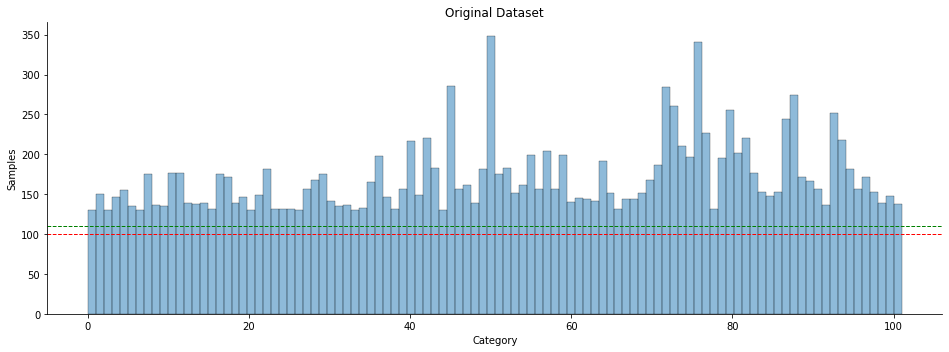

In [ ]:
distribuzione = sns.displot(df, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Original Dataset')

distribuzione.refline(y = 100,
          color = "red",
          lw = 1)
distribuzione.refline(y = 110,
          color = "green",
          lw = 1)

distribuzione.fig.set_size_inches(15,5)

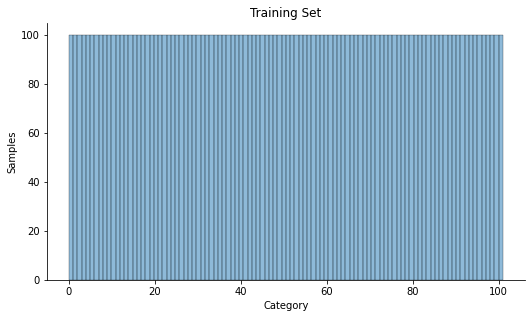

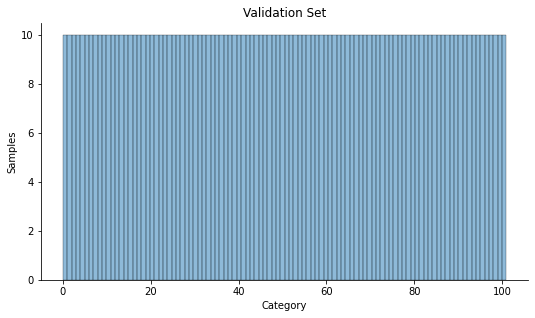

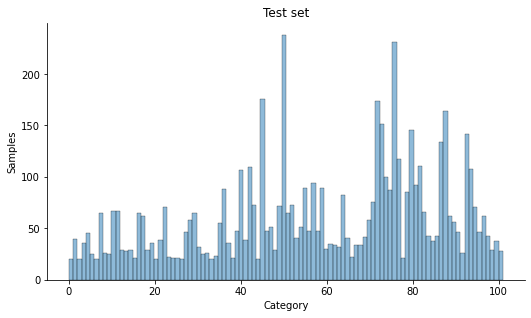

In [ ]:
distribuzione = sns.displot(train_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Training Set')
distribuzione.fig.set_size_inches(8,4)

distribuzione = sns.displot(val_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Validation Set')
distribuzione.fig.set_size_inches(8,4)

distribuzione = sns.displot(test_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Test set')
distribuzione.fig.set_size_inches(8,4)

In [ ]:
# Classi ordinate per numero di campioni
counts = df['Category'].value_counts()
idx = counts.index.tolist()
count_numbers_of_flowers_by_name = {}
for label_number in idx:
  x = counts[label_number]
  count_numbers_of_flowers_by_name[NAMES[int(label_number)]] = x

count_numbers_of_flowers_by_name = pd.DataFrame(count_numbers_of_flowers_by_name.items(), columns=['Category', 'Samples'])
display(count_numbers_of_flowers_by_name)

# TODO: convert this in csv or latex for documentation

,Category,Samples
0,petunia,348
1,passion flower,341
2,wallflower,286
3,water lily,284
4,watercress,274
...,...,...
97,mexican aster,130
98,moon orchid,130
99,bolero deep blue,130
100,canterbury bells,130


## Osservazioni  
Come si può vedere dai grafici le classi nel training/Validation set sono perfettamente ben bilanciate.  
Putroppo però **il numero di campioni (10) per ogni classe è molto basso** per un task di classificazione basato sull'uso di CNN.  

Questo ci fa già riflettere su un  possibile approccio di **Data Augmentation** per poter far fronte a queste carenze di immagini di Training.

## Display Immagini

Ora mostriamo alcune immagini e vediamo come appaiono, per comodità mostriamo un numero ridotto di classi.

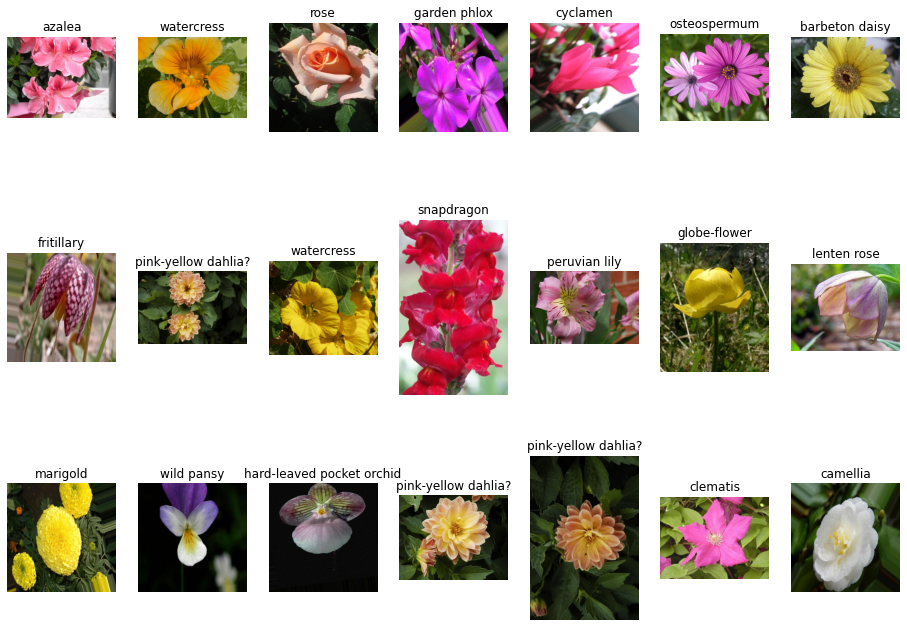

In [ ]:
plot_figure(df)

### Inter Class Similarity 
Osservando le immagini del data set originale abbiamo notato delle similarità tra classi di fiori diverse. Vediamo alcuni esempi:

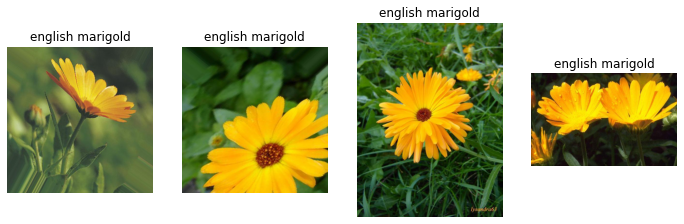

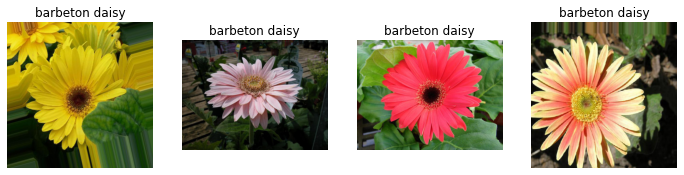

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["english marigold"]), plot_figure_by_class(df, NAMES_ID["barbeton daisy"])  

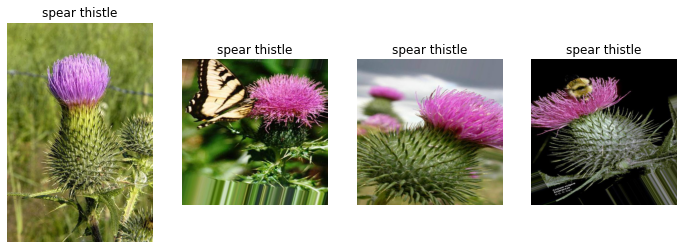

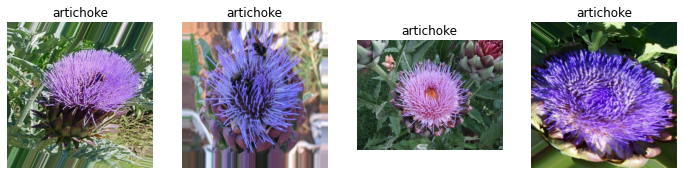

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["spear thistle"]), plot_figure_by_class(df, NAMES_ID["artichoke"]) 

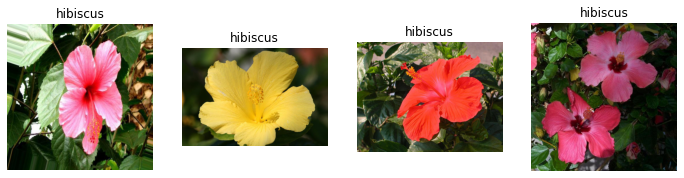

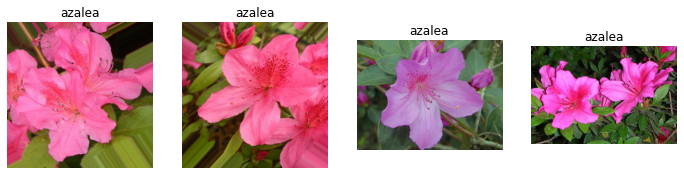

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["hibiscus"]), plot_figure_by_class(df, NAMES_ID["azalea"])  

### Osservazioni  
La presenza di similarità tra alcune classi è un'altro problema da affrontare.    
Avendo poche immagini di training e considerando le limitazioni del data augmentation su un dataset sensibile a possibili distorsioni cromatiche si potrebbe considerare di estrarre **feature handcrafted** dalle nostre immagini, come complemento ad altre possibili features.
(considerazioni da rivalutare se fine tuning)

# Import effettivo dati

In [12]:
# # converting back to string because CNNs need a categorical input
train_set['Category'] = train_set['Category'].astype(str)
test_set['Category']= test_set['Category'].astype(str)
val_set['Category'] = val_set['Category'].astype(str)

gen = tf.keras.preprocessing.image.ImageDataGenerator()
BATCH_SIZE=32

train_generator = gen.flow_from_dataframe(
    dataframe=train_set,
    directory=PATH_JPG,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, # 32 default
    class_mode='categorical',
    shuffle=True, 
    # seed=RANDOM_SEED,
    )

val_generator = gen.flow_from_dataframe(
    dataframe=val_set,
    directory=PATH_JPG,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, # 32 default
    class_mode='categorical',
    shuffle=False, 
    # seed=RANDOM_SEED,
    )

test_generator = gen.flow_from_dataframe(
    dataframe=test_set,
    directory=PATH_JPG,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, # 32 default
    class_mode='categorical',
    shuffle=False, 
    # seed=RANDOM_SEED,
    )

train_generator, val_generator, test_generator

Found 10200 validated image filenames belonging to 102 classes.
Found 1020 validated image filenames belonging to 102 classes.
Found 6149 validated image filenames belonging to 102 classes.


(<keras.preprocessing.image.DataFrameIterator at 0x7f535d3c1e50>,
 <keras.preprocessing.image.DataFrameIterator at 0x7f535d3c1550>)

# Funzione Plot History Model

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def plot_history(history):
  fig = make_subplots(rows=1, cols=3, subplot_titles=["Loss", "Top-1 Accuracy", "Top-3 Accuracy"])

  fig.add_trace(
      go.Scatter(y=history.history['val_loss'], name="val_loss"),
      row = 1, col = 1
  )

  fig.add_trace(
      go.Scatter(y=history.history['loss'], name="train_loss"),
      row = 1, col = 1
  )

  fig.add_trace(
      go.Scatter(y=history.history['val_accuracy'], name="val_top-1_accuracy"),
      row = 1, col = 2
  )

  fig.add_trace(
      go.Scatter(y=history.history['accuracy'], name="train_top-1_accuracy"),
      row = 1, col = 2
  )

  fig.add_trace(
      go.Scatter(y=history.history['val_top_k_categorical_accuracy'], name="val_top-3_accuracy"),
      row = 1, col = 3
  )

  fig.add_trace(
      go.Scatter(y=history.history['top_k_categorical_accuracy'], name="train_top-3_accuracy"),
      row = 1, col = 3
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss", row=1, col=1)
  fig.update_yaxes(title_text="Top-1 Accuracy", row=1, col=2)
  fig.update_yaxes(title_text="Top-3 Accuracy", row=1, col=3)
  fig.show()

# ResNet50

In [15]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import top_k_accuracy_score

#Creazione modello
baseModel = ResNet50(weights='imagenet', include_top=True, input_shape= (224, 224, 3))
#baseModel.summary()

102967424/102967424 [==============================] - 5s 0us/step


In [ ]:
# Freeze layer del baseModel
# con [:19] ottengo 84%
# con [:43] ottengo 82%
for layer in baseModel.layers:
	layer.trainable = False


# Nuova parte Fully Connected
model = Model(inputs=baseModel.input, outputs=baseModel.get_layer('avg_pool').output)
last_layer = baseModel.get_layer('avg_pool').output
last_layer = Flatten(name="flatten")(last_layer)
#last_layer = Dense(512, activation="relu")(last_layer)
last_layer = Dense(102, activation="softmax")(last_layer)
model = Model(inputs=baseModel.input, outputs=last_layer)
model.summary()

In [17]:
#model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=["accuracy"]) 
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3)])


epochs=20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/20
319/319 [==============================] - 85s 232ms/step - loss: 1.1309 - accuracy: 0.7797 - top_k_categorical_accuracy: 0.8638 - val_loss: 0.7426 - val_accuracy: 0.8255 - val_top_k_categorical_accuracy: 0.9284
Epoch 2/20
319/319 [==============================] - 70s 221ms/step - loss: 0.1014 - accuracy: 0.9955 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.6416 - val_accuracy: 0.8480 - val_top_k_categorical_accuracy: 0.9294
Epoch 3/20
319/319 [==============================] - 72s 226ms/step - loss: 0.0390 - accuracy: 0.9999 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5896 - val_accuracy: 0.8490 - val_top_k_categorical_accuracy: 0.9422
Epoch 4/20
319/319 [==============================] - 71s 224ms/step - loss: 0.0214 - accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5725 - val_accuracy: 0.8529 - val_top_k_categorical_accuracy: 0.9471
Epoch 5/20
319/319 [==============================] - 71s 222ms/step - loss: 0.0138 - accuracy: 1.0000 - top

In [21]:
plot_history(history)

In [19]:
score = model.evaluate(test_generator)

193/193 [==============================] - 37s 194ms/step - loss: 0.7039 - accuracy: 0.8343 - top_k_categorical_accuracy: 0.9228


In [20]:
model.save("/content/gdrive/MyDrive/Progetto AML/Models/ResNet50_Augmented.h5")

# ResNet50 - Fine Tuning

In [22]:
# Freeze layer del baseModel - Fine tuning dal 4 blocco di convoluzione
trainable_layer = False
for layer in baseModel.layers:
    if layer.name == "conv4_block1_1_conv":  
        trainable_layer=True
    layer.trainable=trainable_layer




# Nuova parte Fully Connected
model2 = Model(inputs=baseModel.input, outputs=baseModel.get_layer('avg_pool').output)
last_layer = baseModel.get_layer('avg_pool').output
last_layer = Flatten(name="flatten")(last_layer)
#last_layer = Dense(512, activation="relu")(last_layer)
last_layer = Dense(102, activation="softmax")(last_layer)
model2 = Model(inputs=baseModel.input, outputs=last_layer)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [23]:
#model2.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=["accuracy"]) 
model2.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3)])


epochs=20
history2 = model2.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/20
319/319 [==============================] - 87s 255ms/step - loss: 0.8413 - accuracy: 0.8002 - top_k_categorical_accuracy: 0.8950 - val_loss: 2.4102 - val_accuracy: 0.5588 - val_top_k_categorical_accuracy: 0.7490
Epoch 2/20
319/319 [==============================] - 81s 253ms/step - loss: 0.0657 - accuracy: 0.9828 - top_k_categorical_accuracy: 0.9987 - val_loss: 1.1993 - val_accuracy: 0.7304 - val_top_k_categorical_accuracy: 0.8765
Epoch 3/20
319/319 [==============================] - 79s 248ms/step - loss: 0.0605 - accuracy: 0.9857 - top_k_categorical_accuracy: 0.9983 - val_loss: 1.0295 - val_accuracy: 0.7784 - val_top_k_categorical_accuracy: 0.9069
Epoch 4/20
319/319 [==============================] - 80s 249ms/step - loss: 0.0444 - accuracy: 0.9894 - top_k_categorical_accuracy: 0.9984 - val_loss: 0.9118 - val_accuracy: 0.8069 - val_top_k_categorical_accuracy: 0.9196
Epoch 5/20
319/319 [==============================] - 79s 246ms/step - loss: 0.0569 - accuracy: 0.9864 - top

In [24]:
plot_history(history2)

In [25]:
score2 = model2.evaluate(test_generator)

193/193 [==============================] - 38s 191ms/step - loss: 0.9358 - accuracy: 0.8315 - top_k_categorical_accuracy: 0.9219


In [26]:
model2.save("/content/gdrive/MyDrive/Progetto AML/Models/ResNet50_Augmented_FineTuning_Conv4.h5")